# MODELING TRAFFIC-DENSTIY OF THE CITY OF VIENNA
<i> Part 2: Constrained Optimization</i>
***

In this project I attempt to model the traffic-density for the City of Vienna solely based on publicly available data.<br><br>
<b>Data Sources:</b> 
- <u>Road network:</u> The official road network from (https://www.data.gv.at/) consists of information on ~30000 street segments and its respective geolocation and street-type.
- <u>Uber rides:</u> Information on Uber rides per City can be accessed at (https://movement.uber.com/). Uber is splitting the City of Vienna into 1370 subdistricts where travel-time between these starting & ending-areas is reported. Additional categorical information about weekdays or time of the day are available.

<b>Approach:</b><br><br>
<u>Part 1: Simulating Paths</u>
<ul>
    <li>Initialize a network graph consisting of all recorded streets of the City of Vienna.</li>
    <li>Map maximum speed-limit to each network edge dependent on its street-type.</li>
    <li>Calculate the shortest path of streets between pairs of start/end-nodes in the network.</li>
    <li>Collect shortest path information for every start/end combination observed in the set of Uber rides.</li>
</ul>

<u>Part 2: Constrained Optimization</u>
<ul>
    <li>Frame a constrained optimiziation problem to derive a "traffic-coefficient" per each area, representing its traffic-density.</li>
    <li>Analyze traffic-density per area during different times of the day.</li>

<img src="../artifacts/img/cover.jpg" alt="Drawing" style="width: 800px;"/><br>

<left>
    Photo by <a href="https://unsplash.com/@ahmgeek?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Ahmad Tolba</a> on <a href="https://unsplash.com/s/photos/vienna-cars?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
   </left>

### 1 Imports
***

In [1]:
import os
import sys

root = os.environ['HOME']+"/private/vienna-traffic-density/"
sys.path.append(root)

In [2]:
import pickle
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.cm import ScalarMappable
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as Centroid

import params.config as conf
from src.utils import coef_kmh

warnings.filterwarnings("ignore", category=FutureWarning)

### 2 Load Data
***

In [3]:
coefs_path = os.path.join(conf.root_output, "csv", "coefs.csv")
areas_path = os.path.join(conf.root_output, "pkl", "areas.pkl")

coefs_df = pd.read_csv(coefs_path, index_col="area",  dtype={"area": str})
coefs = coefs_df.iloc[:,-1]

coefs_df.head()

,0,1,2,3,4,5,6,7,8,9,10
area,,,,,,,,,,,
0001,0.160704,0.160704,0.160704,0.160704,0.160704,0.160704,0.160704,0.160704,0.160704,0.160704,0.160704
0002,0.328837,0.720000,0.720000,0.720000,0.720000,0.720000,0.720000,0.720000,0.720000,0.720000,0.720000
0003,0.416809,0.416809,0.416809,0.416809,0.416809,0.416809,0.416809,0.416809,0.416809,0.416809,0.416809
0004,0.415815,0.415815,0.415815,0.415815,0.415815,0.415815,0.415815,0.415815,0.415815,0.415815,0.415815
0005,0.206465,0.206465,0.206465,0.206465,0.206465,0.206465,0.206465,0.206465,0.206465,0.206465,0.206465


In [4]:
kmh = coef_kmh(coefs=coefs)
kmh.head()

area
0001    22.401502
0002     5.000000
0003     8.637049
0004     8.657689
0005    17.436370
Name: 10, dtype: float64

In [5]:
with open(areas_path, 'rb') as f:
    areas = pickle.load(f)

### 3. Visuals
***

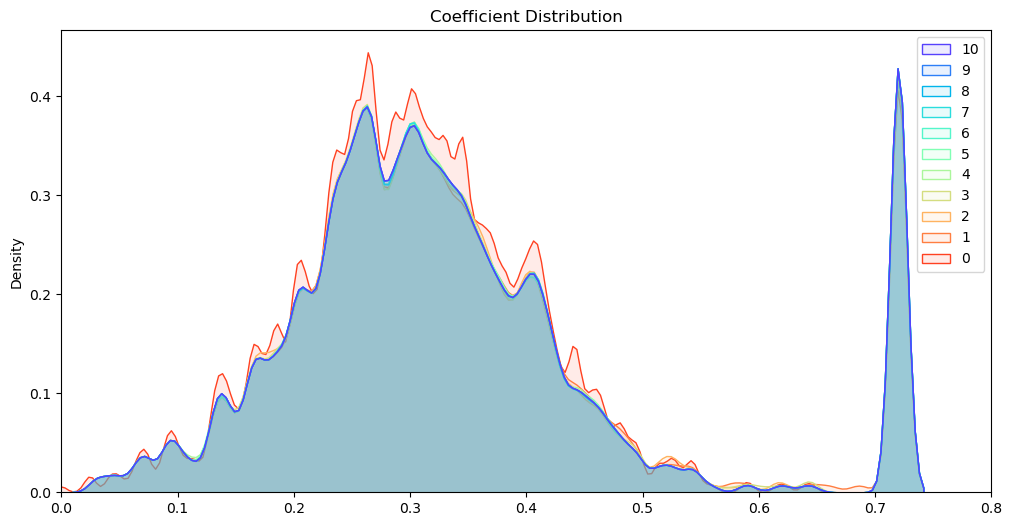

In [6]:
plt.figure(figsize=(12,6))
sns.kdeplot(
    data=coefs_df, 
    hue_order=coefs_df.columns[::-1], 
    bw_adjust=0.2, 
    palette="rainbow", 
    shade=True, 
    alpha=0.1, 
    lw=1,
    label=coefs_df.columns
)
plt.xlim(0,0.8)
plt.title("Coefficient Distribution")
plt.show()

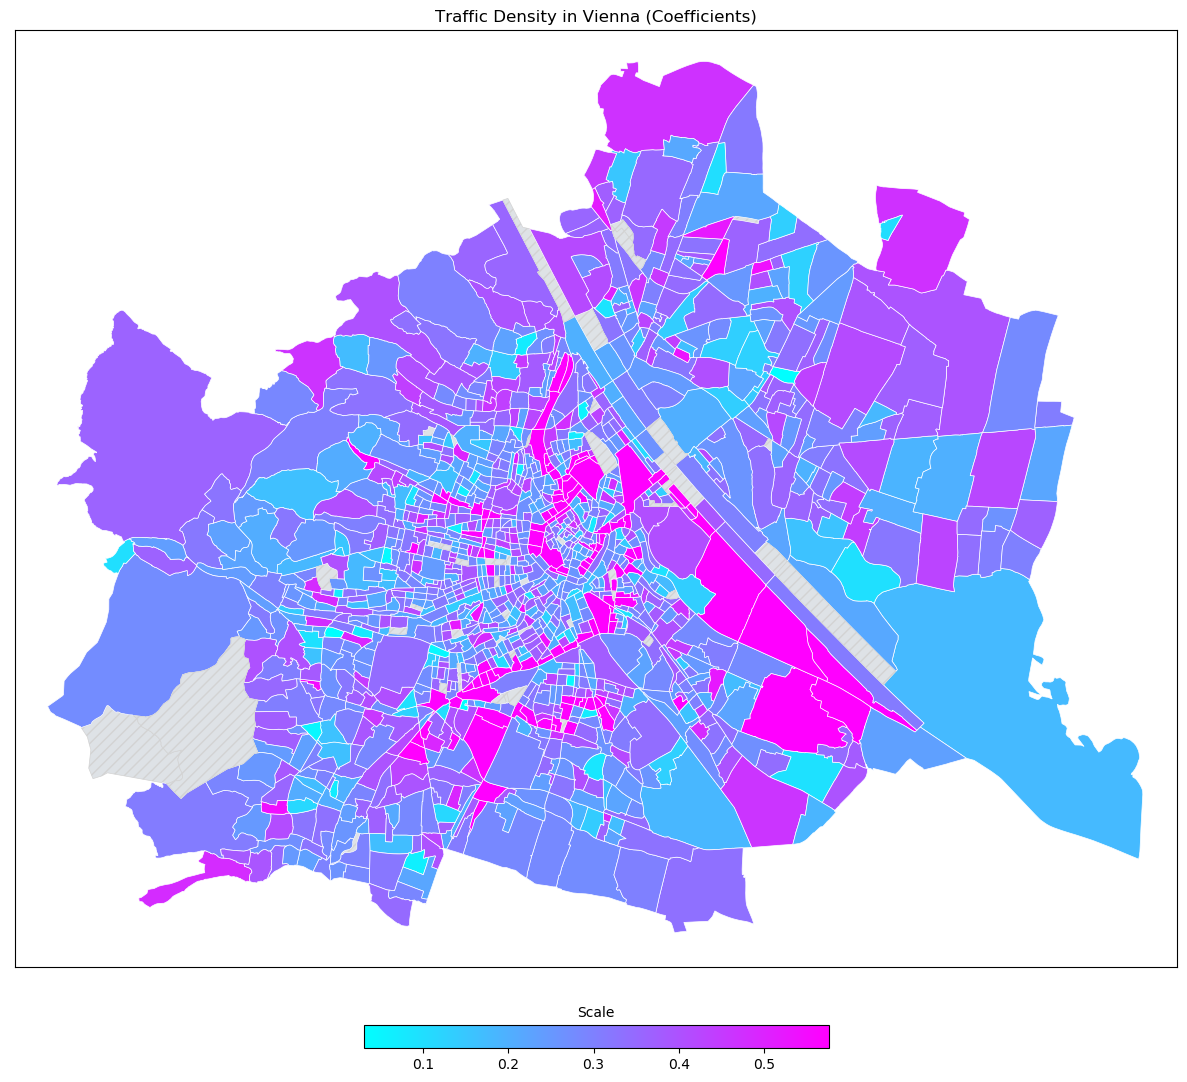

In [7]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(coefs), vmax=np.max(coefs)*0.8)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Coefficients)", fontsize=12)

for key,val in areas.polygons.items():
    
    # Skipping plotting outer areas
    if key in conf.outer_areas:
        continue
    
    # Color areas according to coefficients
    elif key in coefs.index:
        density = norm(coefs[key])

        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Areas without coefficients are greyed out
    else:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5
        ))    

    # x_center, y_center = Centroid(val).centroid.coords[0]
    # ax.text(x=x_center, y=y_center, s=key, ha="center")
    
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Scale", fontsize=10)
plt.savefig(conf.root_img+"/map-traffic.png")
plt.show()

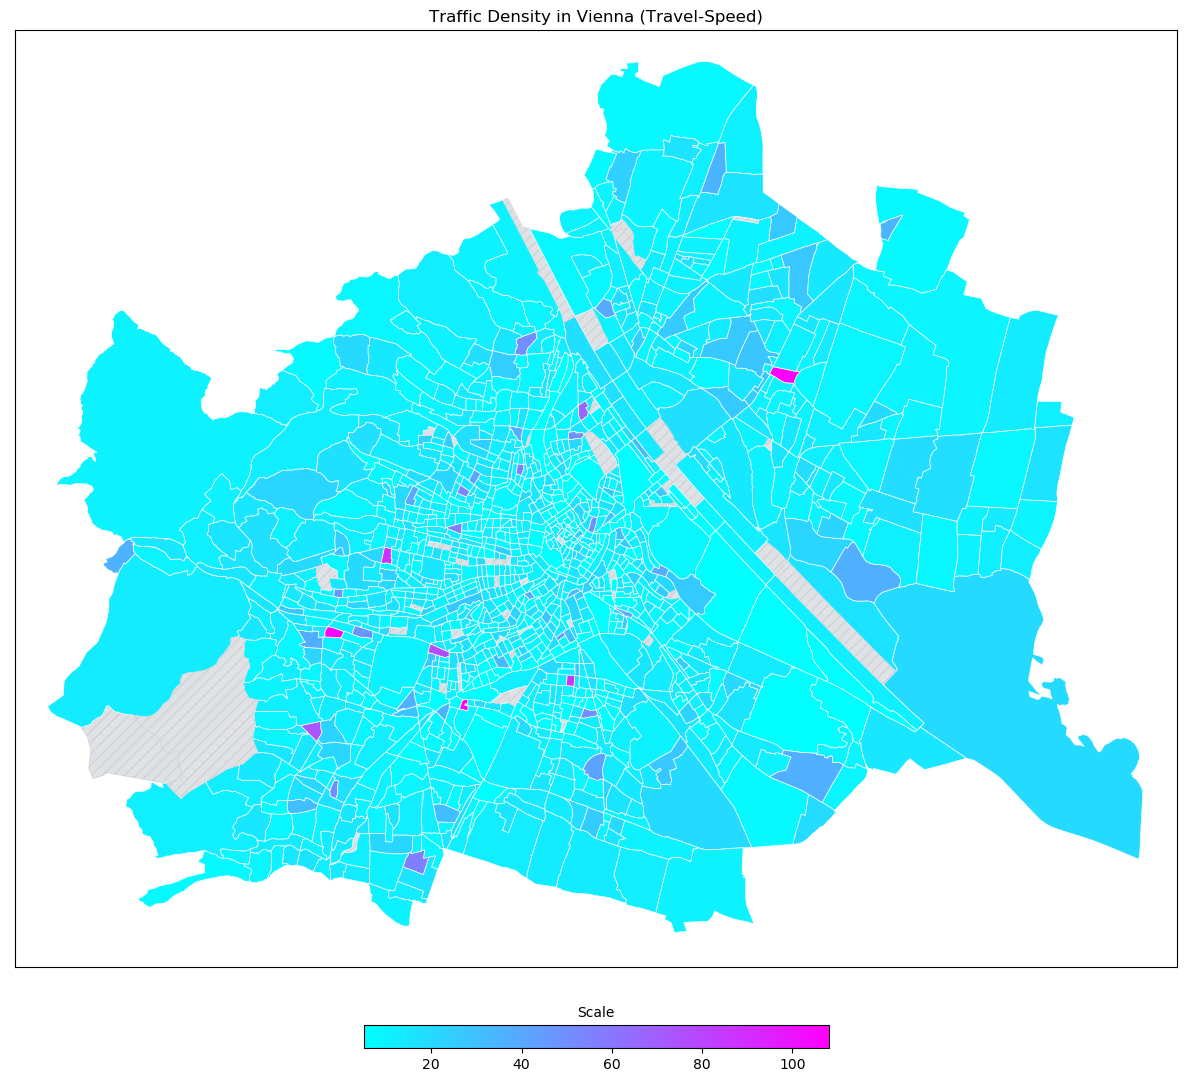

In [8]:
# Get colormap
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=np.min(kmh), vmax=np.max(kmh)*0.9)
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,15.2))

ax.set_xlim(16.17, 16.59)
ax.set_ylim(48.11, 48.33)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title("Traffic Density in Vienna (Travel-Speed)", fontsize=12)

for key,val in areas.polygons.items():
    
    # Skipping plotting for outer areas
    if key in conf.outer_areas:
        continue
    
    # Color areas according to coefficients/speed
    elif key in coefs.index:
        density = norm(kmh[key])

        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor=cmap(density), 
            edgecolor="white",
            linewidth=0.5))
    
    # Areas without coefficients/speed are greyed out
    else:
        ax.add_patch(Polygon(val, 
            closed=True, 
            facecolor="#dee2e6", 
            edgecolor="lightgray",
            hatch=r"///",
            linewidth=0.5
        ))

# Add colormap
cbar = fig.colorbar(
    mappable=sm,
    orientation="horizontal",
    shrink=0.4, 
    pad=0.05,
    ax=ax)

cbar.ax.set_title("Scale", fontsize=10)
plt.savefig(conf.root_img+"/map-speed.png")
plt.show()